# Mean Forecast + Safety Stock

This notebook shows a clear workflow for using the mean forecast with safety stock.
It first optimizes safety stock without aggregation, then repeats the process with an aggregation window.


## Setup


In [10]:
import random
from dataclasses import replace

import pandas as pd

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    evaluate_aggregation_and_service_level_factor_costs,
    evaluate_service_level_factor_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    optimize_point_forecast_policy_and_simulate_actuals,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)

## Generate Sample Data


In [11]:
history_mean = 18
history_std = 8
forecast_mean = 16
forecast_std = 2
replenishment_start_period = 90

rows = generate_standard_simulation_rows(
    n_unique_ids=300,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    holding_cost_per_unit=3,
    stockout_cost_per_unit=1.0,
    order_cost_per_order=12.5,
    #seed=7,
    lead_time=3,
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")

# Overwrite current stock to simulate a known starting inventory position.
df["current_stock"] = 25

# Drop is_forecast so the cutoff defines the backtest/evaluation split.
df = df.drop(columns=["is_forecast"])

cutoff_period = replenishment_start_period
cutoff = sorted(df["ds"].unique())[cutoff_period - 1]
rows = standard_simulation_rows_from_dataframe(df, cutoff=cutoff)

candidate_factors = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94
                       ]


## Split Backtest vs Forecast


In [12]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

forecast_rows_actuals = [
    replace(row, actuals=_sample_int(history_mean, history_std), demand=_sample_int(history_mean, history_std))
    for row in forecast_rows
]
forecast_rows = forecast_rows_actuals


backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

## Step 1: Optimize Safety Stock (No Aggregation)


In [13]:
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=0.9,
    fixed_rmse=backtest_rmse,
)

sigma_costs = evaluate_service_level_factor_costs(
    point_configs,
    candidate_factors=candidate_factors,
)
sigma_cost_rows = [
    {"unique_id": uid, "service_level_factor": factor, "total_cost": cost}
    for uid, factors in sigma_costs.items()
    for factor, cost in factors.items()
]
sigma_cost_df = pd.DataFrame(sigma_cost_rows)
sigma_cost_df


,unique_id,service_level_factor,total_cost
0,A,0.10,2650.5
1,A,0.12,2650.5
2,A,0.14,2650.5
3,A,0.16,2658.5
4,A,0.18,2658.5
...,...,...,...
10795,SKU-300,0.86,2716.0
10796,SKU-300,0.88,2716.0
10797,SKU-300,0.90,2700.0
10798,SKU-300,0.92,2700.0


In [14]:
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=0.9,
    fixed_rmse=backtest_rmse,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_factors,
)
best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    forecast_rows,
    service_level_factor=best_factors,
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
mean_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
)

mean_decision_df = replenishment_decision_rows_to_dataframe(
    mean_decision_rows,
    library="pandas",
)
mean_decision_df


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,29,35,15,17,0,25,0,1.367845,25,0,0,29,10,10,0.1,1,None
1,A,2031-06-23,31,30,19,18,0,0,0,1.367845,0,0,0,60,40,30,0.1,1,None
2,A,2031-07-23,17,21,17,14,0,0,0,1.367845,0,0,0,77,61,21,0.1,1,None
3,A,2031-08-22,21,19,17,16,29,29,10,1.367845,0,0,10,69,51,0,0.1,1,None
4,A,2031-09-21,21,23,18,14,31,41,18,1.367845,0,0,18,59,43,0,0.1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,SKU-300,2033-06-12,18,14,19,17,26,45,31,12.023228,0,0,31,55,25,0,0.9,1,None
8996,SKU-300,2033-07-12,18,18,16,17,18,49,31,12.023228,0,0,31,55,25,0,0.9,1,None
8997,SKU-300,2033-08-11,16,16,13,17,19,50,34,12.023228,0,0,34,52,22,0,0.9,1,None
8998,SKU-300,2033-09-10,33,33,17,17,18,52,19,12.023228,0,0,19,67,37,0,0.9,1,None


### Plot (No Aggregation)


0     10
1     30
2     21
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Mean forecast decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

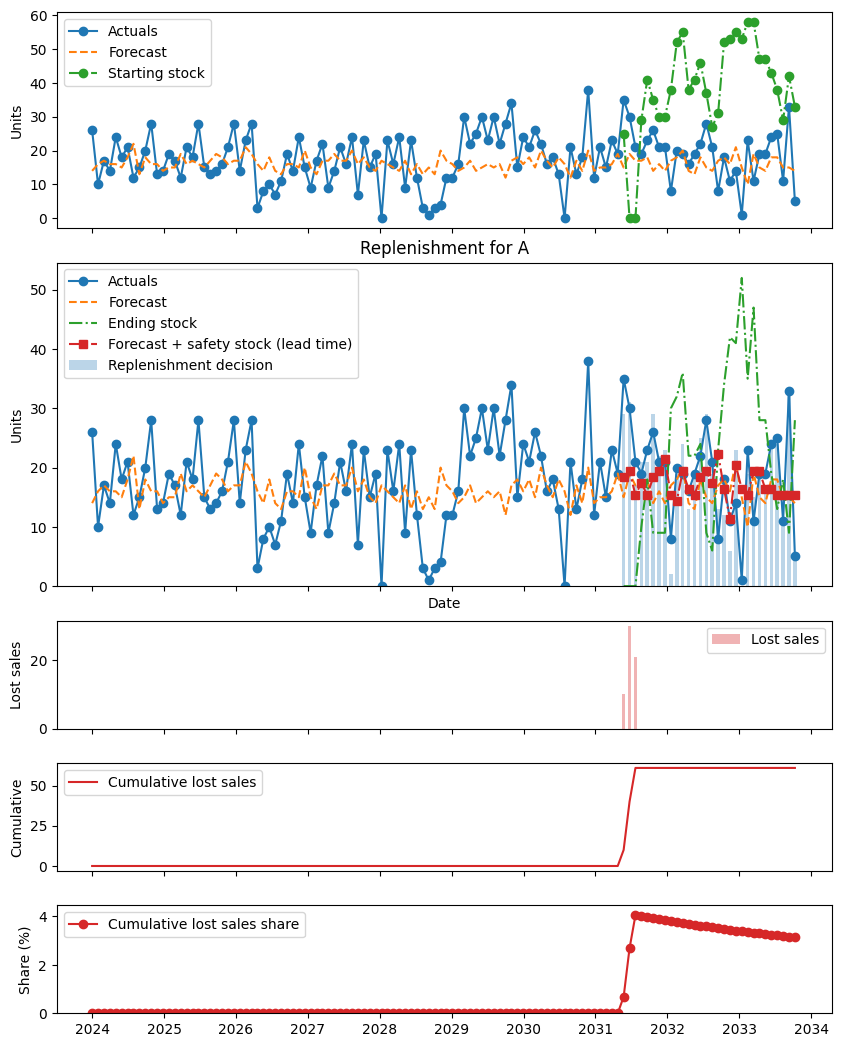

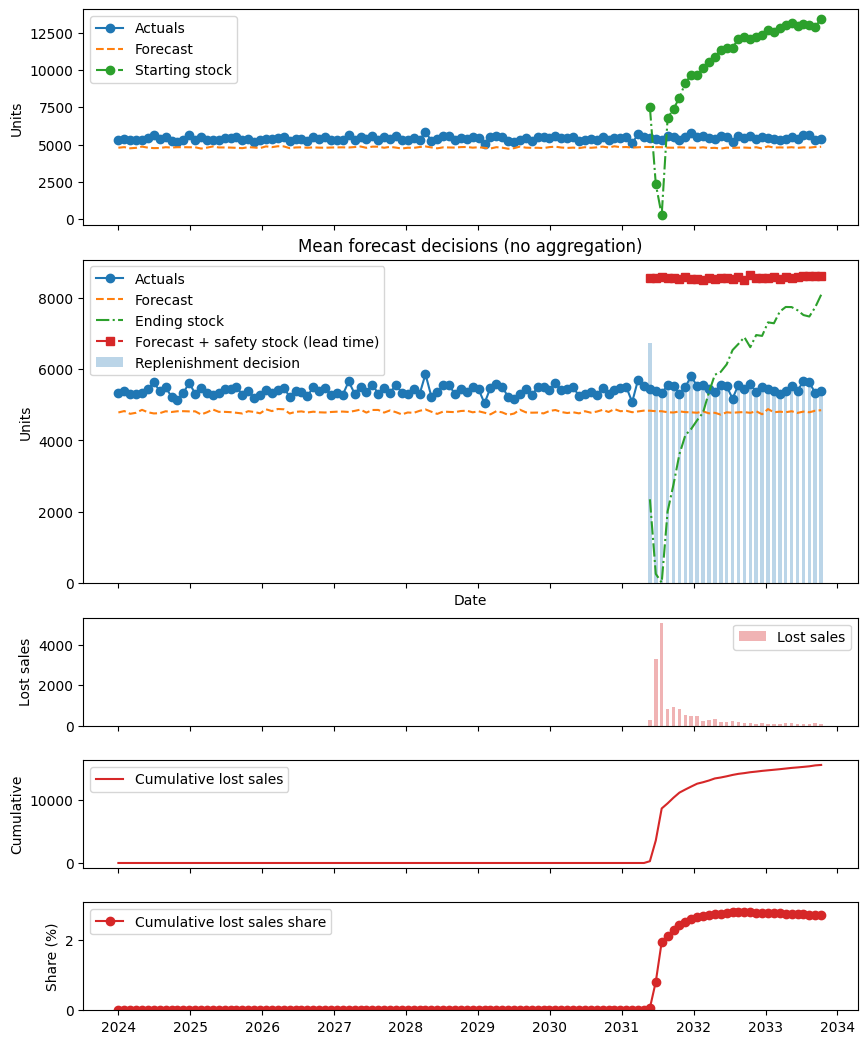

In [15]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, mean_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    mean_decision_df,
    aggregate=True,
    title="Mean forecast decisions (no aggregation)",
)

In [16]:
mean_decision_df

,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,29,35,15,17,0,25,0,1.367845,25,0,0,29,10,10,0.1,1,None
1,A,2031-06-23,31,30,19,18,0,0,0,1.367845,0,0,0,60,40,30,0.1,1,None
2,A,2031-07-23,17,21,17,14,0,0,0,1.367845,0,0,0,77,61,21,0.1,1,None
3,A,2031-08-22,21,19,17,16,29,29,10,1.367845,0,0,10,69,51,0,0.1,1,None
4,A,2031-09-21,21,23,18,14,31,41,18,1.367845,0,0,18,59,43,0,0.1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,SKU-300,2033-06-12,18,14,19,17,26,45,31,12.023228,0,0,31,55,25,0,0.9,1,None
8996,SKU-300,2033-07-12,18,18,16,17,18,49,31,12.023228,0,0,31,55,25,0,0.9,1,None
8997,SKU-300,2033-08-11,16,16,13,17,19,50,34,12.023228,0,0,34,52,22,0,0.9,1,None
8998,SKU-300,2033-09-10,33,33,17,17,18,52,19,12.023228,0,0,19,67,37,0,0.9,1,None


## Step 2: Optimize Aggregation Window + Safety Stock


In [17]:
agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=[3, 4, 5],
    candidate_factors=candidate_factors,
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    forecast_rows,
    service_level_factor=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_mean_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_mean_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    agg_mean_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
)
agg_mean_decision_df = replenishment_decision_rows_to_dataframe(
    agg_mean_decision_rows,
    library="pandas",
)
agg_mean_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,114,35,17.000000,33.333333,0,25,0,3.957524,25,0,0,114,10,10,0.1,3,None
1,A,2031-06-23,0,30,17.666667,33.666667,0,0,0,3.957524,0,0,0,114,40,30,0.1,3,None
2,A,2031-07-23,0,21,17.333333,32.000000,0,0,0,3.957524,0,0,0,114,61,21,0.1,3,None
3,A,2031-08-22,66,19,16.333333,32.000000,114,114,95,3.957524,53,34,95,66,0,0,0.1,3,None
4,A,2031-09-21,0,23,16.000000,32.333333,0,95,72,3.957524,34,11,72,66,0,0,0.1,3,None


### Plot (Optimized Aggregation)


0     10
1     30
2     21
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Mean forecast decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

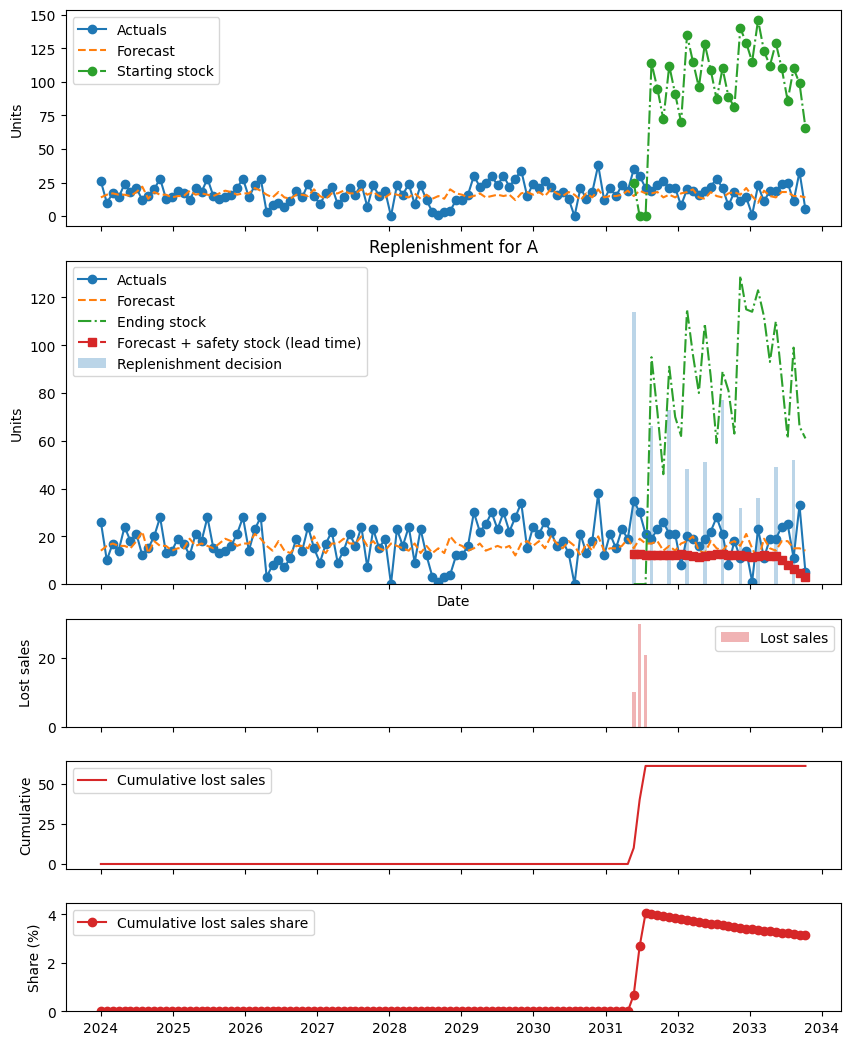

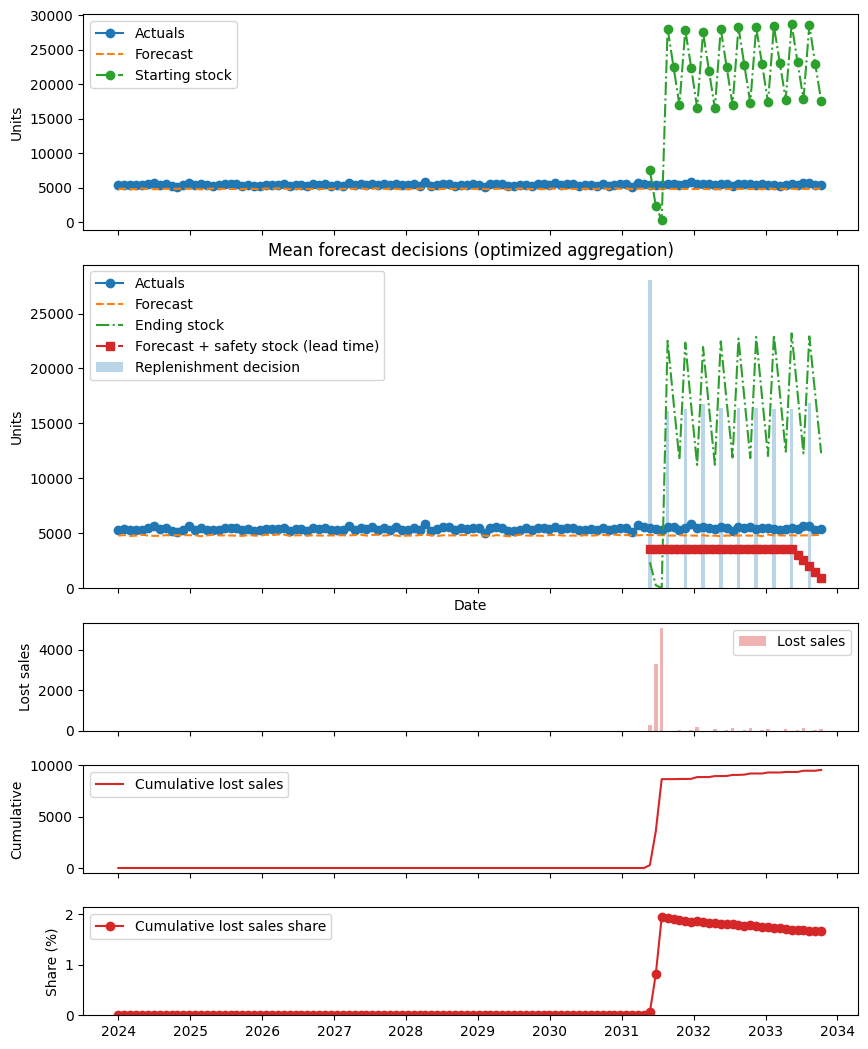

In [18]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_mean_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_mean_decision_df,
    aggregate=True,
    title="Mean forecast decisions (optimized aggregation)",
)

## ROP policy (mean + safety stock)
This section uses a reorder-point trigger instead of ordering every period.


In [ ]:
rop_point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=1.0,
    policy_mode="rop",
)
rop_optimized = optimize_service_level_factors(
    rop_point_configs,
    candidate_factors=candidate_factors,
)
rop_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in rop_optimized.items()
}

rop_eval_configs = build_point_forecast_article_configs_from_standard_rows(
    forecast_rows,
    service_level_factor=rop_factors,
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
    policy_mode="rop",
)
rop_simulations = simulate_replenishment_for_articles(rop_eval_configs)
rop_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_simulations,
    sigma=rop_factors,
    fixed_rmse=backtest_rmse,
)
rop_decision_df = replenishment_decision_rows_to_dataframe(
    rop_decision_rows,
    library="pandas",
)
rop_decision_df.head()


In [ ]:
plot_replenishment_decisions(df, rop_decision_df, unique_id=example_id)